# Project 5 - Object Detection

Group Members:

Abram Beazer
Bryant Hinton
Jared Smith

### Due Date: *Friday, April 5th*

### What to Submit
Submit this iPython Notebook--containing all your code for the programming exercises below--on [LearningSuite](https://learningsuite.byu.edu/).

Your notebook file should produce the relevant plots and also provide a short write-up with answers to the questions below (at the end of this notebook).

Please also fill in here the time that each part took you:
* 1. Part A - Feature Extraction: <span style="color:red;">2 Hours</span>
* 2. Part B - Vector Quantization: <span style="color:red;">2.5 Hours</span>
* 3. Part C - Classifier Training: <span style="color:red;">.5 Hours</span>
* 4. Part D - Sliding Window Detection: <span style="color:red;">6 Hours</span>
* 5. Part E - Evaluation: <span style="color:red;">3 Hours</span>
* 6. Challenges: <span style="color:red;">0 Hours</span>
* 7. Write-up: <span style="color:red;">.5 Hours</span>


## Background - Object Detection

For this assignment, you will implement an object detection pipeline. Your project will leverage a set of training images (both positive examples where the object of interest is present and negative examples where it is not).  Your program will divide a query/test image up into image regions or _windows_ and convert each window into a feature vector representation (based on Bag-of-Words and/or HOG).  Using the training data, you will use a machine-learning algorithm to train a classification model which will predict the probability of each window (its derived feature vector, actually) containing the object to be detected.

This project will apply several of the things you’ve done previously, but also incorporate the idea of supervised machine learning.  You will need to implement both the feature extraction and the classification parts of the pipeline.  Here are the steps that you will follow:

1) Extract and cluster feature descriptors - You will extract features (feature _descriptors_) from a variety of images and cluster them into $K$ discrete clusters (visual words).

2) Vector Quantization - Given the visual vocabulary, each image is converted into a Bag-of-Words representation (a $K$-dimensional histogram).

3) Train Detection Classifier - Given the positive and negative training examples, a Support Vector Machine (SVM) is trained to distinguish between the object and everything else.

4) Sliding Window - Finds the actual object in an image by iterative considering windows at different locations and scales.


## Data

For this project, we will provide you with a dataset comprised of Butterflies and Birds/Flowers.  Your task will be to detect the birds that are present in a set of test images comprised of all three types of images.

<span style="color:red;">I will post the data tomorrow.  If you want to get started in the meantime, you can download bird images here: [CUB-200-2011 Dataset](http://www.vision.caltech.edu/visipedia/CUB-200-2011.html).</span>

### Part A: Extract and Cluster Feature Descriptors

To create the visual vocabulary, you will need to sample (grab a subset) from amongst all the sift descriptors of a large number of images. You want a representative set of descriptors, so you should ideally grab from images of all categories you intend to recognize and also from both the set of
training images and the set of test images. A useful routine for sampling is `numpy.random.permutation(n)[0:m]` which will generate a random subset of $m$ numbers between $0$ and $n-1$. Generate a vector of column indices in this way and use it to grab a subset of $m$ columns from a given image’s descriptor matrix.

So, once you have $m$ descriptors from each image, you will concatenate these together into a single matrix. Each column is a single descriptor, so with SIFT features, this matrix has 128 rows. Let us suppose that there are a total of $M$ columns/descriptors.

Now this matrix represents $M$ distinct points in $R^{128}$. The k-means algorithm will partition these $M$ 128-dimensional points into $K$ clusters, for some value $K$ that is provided. $K$ determines how many words will be in our visual vocabulary. So, you will take his large 128 x $M$ matrix, pass it to k-means along with the desired number of clusters $K$, and kmeans will return a set of $K$ 128-dimensional points each representing the center of one of the clusters. These $K$ points form your visual vocabulary.

Resources that you may find useful:
* [sklearn.cluster.KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) [[Examples]](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#examples-using-sklearn-cluster-kmeans)
* [sklearn.cluster.MiniBatchKMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html)




In [3]:
# Your Code Here
import numpy as np
from sklearn.cluster import KMeans
import pickle
import matplotlib.pyplot as plt

import cub_dataset
CUB = cub_dataset.CUB_Dataset()
CUB_TRN = CUB.getTrainingSet()

createCubTrn = False
K = 50
m = 100

if createCubTrn is True:
    
    positiveM = []
    for imgnum in CUB_TRN:
        f,d = CUB.getSIFTfeatures(imgnum,bbox_only=True) # Get only the features within the bounding box
        n = len(d)
        columnIndices = np.random.permutation(n)[0:m]
        for n in columnIndices:
            positiveM.append(d[n])

   
    kmeansCubTrn = KMeans(n_clusters = K).fit(positiveM)

    with open("computedData/cub_trn.npy", "wb") as f:
        pickle.dump(kmeansCubTrn, f, pickle.HIGHEST_PROTOCOL)
else:
    with open("computedData/cub_trn.npy", "rb") as f:
        kmeansCubTrn = pickle.load(f)

print(kmeansCubTrn)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=50, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


### Part B: Vector Quantization - Represent each Image as a Bag-of-Words

Vector Quantization is the process of taking this visual vocabulary (the $K$ cluster centers) and converting the list of descriptors representation into a bag of visual words, a histogram identifying, for each visual word (each bin in the histogram), the fraction of the SIFT descriptors for which that visual word, or cluster center, is the closest one (in the 128-dimensional space).

Each image is thus converted using the visual vocabulary into a histogram with $K$ bins, or equivalently a feature vector with $K$ dimensions. Each descriptor in an image is mapped as a vote for the cluster whose center that given descriptor is closest to.

You can use the KMeans object you trained (fit) in Part A to predict which visual word/cluster each given descriptor is closest to.  Aggregating the cluster predictions for all descriptors in an image or window produces the Bag-of-Visual-Words representation ($K$-dimensional histogram) for the image/window.


![alt text](pipeline.png)

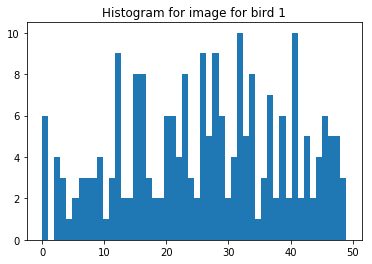

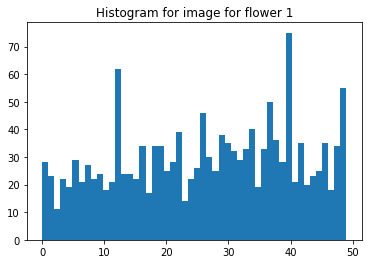

In [4]:
# Your Code Here
import flowers_dataset
FL = flowers_dataset.Flowers_Dataset()
FL_TRN = FL.getTrainingSet()

CUB_TST = CUB.getTestSet()
FL_TST = FL.getTestSet()


createCubHist = False
createFlHist = False

if createCubHist is True:
    quantizedCub = {}
    for imgnum in CUB_TRN:
        f,d = CUB.getSIFTfeatures(imgnum)
        histogram = kmeansCubTrn.predict(d)
        quantizedCub[imgnum] = np.histogram(histogram, bins=np.arange(K))[0]
    with open("computedData/cub_hist.npy", "wb") as f:
        pickle.dump(quantizedCub, f, pickle.HIGHEST_PROTOCOL)
else:
    with open("computedData/cub_hist.npy", "rb") as f:
        quantizedCub = pickle.load(f)

f,d = CUB.getSIFTfeatures(1)
histogram = kmeansCubTrn.predict(d)
plt.title("Histogram for image for bird 1")
plt.hist(histogram, bins=K)
plt.show()
        

if createFlHist is True:
    quantizedFl = {}
    for imgnum in FL_TRN:
        f, d = FL.getSIFTfeatures(imgnum)
        histogram = kmeansCubTrn.predict(d)
        quantizedFl[imgnum] = np.histogram(histogram, bins=np.arange(K))[0]
    with open("computedData/fl_hist.npy", "wb") as f:
        pickle.dump(quantizedFl, f, pickle.HIGHEST_PROTOCOL)
else:
    with open("computedData/fl_hist.npy", "rb") as f:
        quantizedFl = pickle.load(f)

f,d = FL.getSIFTfeatures(1)
histogram = kmeansCubTrn.predict(d)
plt.title("Histogram for image for flower 1")
plt.hist(histogram, bins=K)
plt.show()


### Part C: Train the Detection Classifier

To perform detection, you will using supervised machine learning to train a binary classifier using the labeled data that you're given (positive image windows with the object to be detected, negative image windows without the object).  We will be using Support Vector Machines (SVMs) as our classifier for this project. To train the SVM, you provide a set of feature vectors in the form of a matrix (the size is $K$ by the total number of training images, both positive and negative) and a corresponding label vector (generally $+1$ at the indices where the feature vector is from the positive set and $-1$ corresponding to the indices of the negative feature vectors).

Resources that you may find useful:
* [Support Vector Machines (sklearn.svm)](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm)
    * [User Guide](https://scikit-learn.org/stable/modules/svm.html#svm) and  [Tips on Practical Use](https://scikit-learn.org/stable/modules/svm.html#tips-on-practical-use)
    * [Another Tutorial](https://www.learnopencv.com/svm-using-scikit-learn-in-python/)
* [OpenCV SVM Class](https://docs.opencv.org/3.4.1/d1/d2d/classcv_1_1ml_1_1SVM.html)
    * [OpenCV SVM Tutorial](https://docs.opencv.org/3.4/d3/d02/tutorial_py_svm_index.html)



In [5]:
# Your Code Here
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn import tree

train_model = False;

if train_model:
    training_features = []
    training_labels = []
    for key, value in quantizedCub.items():
        training_features.append(value)
        training_labels.append(1)
    for key, value in quantizedFl.items():
        training_features.append(value)
        training_labels.append(-1)

    clf = SVR(kernel='rbf', gamma='auto', epsilon=.4)
    clf.fit(training_features, training_labels)
    with open("computedData/clf_svr.npy", "wb") as f:
            pickle.dump(clf, f, pickle.HIGHEST_PROTOCOL)
else:
    with open("computedData/clf_svr.npy", "rb") as f:
        clf = pickle.load(f)


image_num = CUB_TST[2]
f,d = CUB.getSIFTfeatures(image_num)
histogram = kmeansCubTrn.predict(d)
new_instance = np.histogram(histogram, bins=np.arange(K))[0]

print(new_instance)
predictions = clf.predict([new_instance])
print(predictions)

correct_count = 0
total_count = 0

for cub_index in CUB_TST:
    if total_count == 20:
         break
    f,d = CUB.getSIFTfeatures(cub_index)
    histogram = kmeansCubTrn.predict(d)
    new_instance = np.histogram(histogram, bins=np.arange(K))[0]
    predictions = clf.predict([new_instance])
    total_count += 1
    if predictions > .50:
        correct_count += 1
        
Accuracy = correct_count / total_count
print("Is Bird Accuracy:", Accuracy)

correct_count = 0
total_count = 0
for cub_index in FL_TST:
    if total_count == 20:
        break
    f,d = FL.getSIFTfeatures(cub_index)
    histogram = kmeansCubTrn.predict(d)
    new_instance = np.histogram(histogram, bins=np.arange(K))[0]
    predictions = clf.predict([new_instance])    
    total_count += 1
    if predictions <+ .50:
        correct_count += 1
        
Accuracy = correct_count / total_count
print("Is not Bird Accuracy:", Accuracy)
    

[13  6 17 13  7 14  4  6 12  7 16 15 21  8  2 14  7 20  8  8 20 13  7 15
 14  3 14 10  3  4  1 16  4 18 18 13 14 18 12  4 20  6  6  0  2  7  7 11
 16]
[0.60002313]
Is Bird Accuracy: 1.0
Is not Bird Accuracy: 1.0


### Part D: Sliding Window Detection

Detection means also finding the location of an object in an image.  Therefore, the classifier, which was trained in part C, needs to be used on a sliding window accross the image. Each window or slice of the image is run through the classifier and the windows with the highest confidence for containing the object is marked with a bounding box.

Remember that you will need to determine a detection threshold and, moreover, perform Non-maximal Suppresssion (NMS) to eliminate multiple detections of the same bird.  Also remember that it's up to you what set of scales you use for your sliding window, and likewise whether you use a "stride" to skip a few pixels each time between windows.

![alt text](sliding-window.gif)

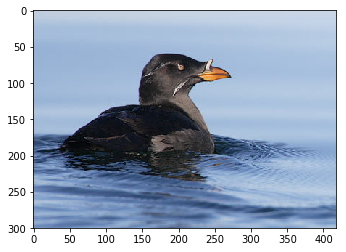

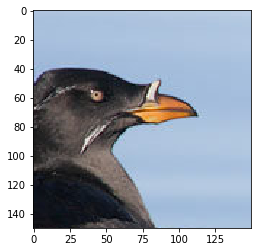

In [60]:
import cv2

sift = cv2.xfeatures2d.SIFT_create()

best_pre = 0

def slide(img, show=True):
    best_pre = 0
    h, w, c = img.shape
    stride = 20
    sizes = [h//2, h//3, h//4]
    conf = np.zeros((len(sizes), h, w))
    for s in range(0, len(sizes)):
        size = sizes[s]
        for y in range(0,h,stride):
            if y+size >= w:
                break           
            for x in range(0,w,stride):
                if x+size < h:                    
                    window = img[x:x+size, y:y+size]     
                    f,d = sift.detectAndCompute(window, None)
                    
                    if d is None:
                        continue
                    histogram = kmeansCubTrn.predict(d)
                    new_instance = np.histogram(histogram, bins=np.arange(K))[0]
                    predictions = clf.predict([new_instance])
                    if predictions[0] > best_pre:
                        best_pre = predictions[0]
                        best_window = window
                else:
                    break
    if show is True:
        plt.imshow(best_window)
        plt.show()
        S, X, Y = np.unravel_index(conf.argmax(), conf.shape)

test_img = CUB.getImage(400)
plt.imshow(test_img)
plt.show()
slide(test_img)

### Part E: Evaluation

You will now run your sliding window detector on the test images we have provided.  Note that there are two test sets, as described here:

* Set A - This set contains <span style="color:red;">TBD</span> images, each containing either a bird or something else.  _You will not need to do sliding window on this set, Set A is to gauge the accuracy of your detector on a window by window basis, simply predict bird vs. not bird_.

* Set B - This set contains <span style="color:red;">TBD</span> images, many of them with multiple birds present.  On this set, you *will* use sliding window detection, trying to detect the locations of each bird present.

For each of the two sets you will generate a detection accuracy curve.  For Set A, you will generate a Precision-Recall curve.  For Set B, you will generate a Miss Rate vs. False Positives per Image curve.  Accuracy in both cases will be judged by the Area Under the Curve (AUC) metric.  You should use the scikit-learn's [`auc()` function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html#sklearn.metrics.auc) to compute this value.  For The PR curves themselves, however, you will generate these yourself.

The student in the class with the best accuracy on each test set, as measured by AUC, will receive 20 points of extra credit.  There are two 20 point bonuses available, one for the best performance on each set.


Resources for P-R Curves that you may find useful:
* scikit-learn's page on [Precision-Recall](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)
* scikit-learn's [`precision-recall-curve()` function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html#sklearn.metrics.precision_recall_curve)

Note than for Set A, the highest AUC wins.  For Set B, however, the lowest AUC wins.

len 5794
Is Bird Accuracy: 1.0
Is not Bird Accuracy: 0.9995098039215686
Area Under the Curve: 1.0


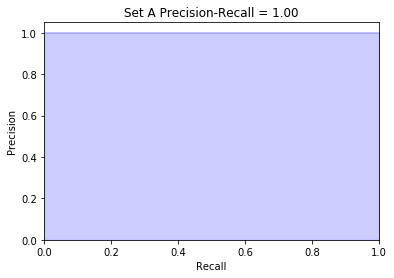

In [131]:
#Test Set A

correct_count = 0
total_count = 0
print("len", len(CUB_TST))
y_true = []
y_scores = []
for cub_index in CUB_TST:
    f,d = CUB.getSIFTfeatures(cub_index)
    histogram = kmeansCubTrn.predict(d)
    new_instance = np.histogram(histogram, bins=np.arange(K))[0]
    y_true.append(1)
    predictions = clf.predict([new_instance])
    y_scores.append(predictions[0])
    total_count += 1
    if predictions > .50:
        correct_count += 1
        
Accuracy = correct_count / total_count
print("Is Bird Accuracy:", Accuracy)

correct_count = 0
total_count = 0
for cub_index in FL_TST:
    f,d = FL.getSIFTfeatures(cub_index)
    histogram = kmeansCubTrn.predict(d)
    new_instance = np.histogram(histogram, bins=np.arange(K))[0]
    y_true.append(0)
    predictions = clf.predict([new_instance]) 
    y_scores.append(predictions[0])
    total_count += 1
    if predictions <+ .50:
        correct_count += 1
        
Accuracy = correct_count / total_count
print("Is not Bird Accuracy:", Accuracy)

from sklearn import metrics
from sklearn.utils.fixes import signature
   
precision, recall, _ = metrics.precision_recall_curve(y_true, y_scores)
average_precision = metrics.average_precision_score(y_true, y_scores)
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_scores)
print("Area Under the Curve: " + str(metrics.auc(fpr, tpr)))

step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Set A Precision-Recall = {0:0.2f}'.format(average_precision))
plt.show()

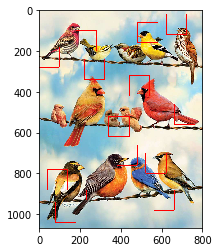

In [62]:
from numpy import unravel_index

def drawBox(img, x, y, s):
    topLeftX = x
    topLeftY = y
    bottomLeftX = topLeftX
    bottomLeftY = topLeftY + s
    topRightX = topLeftX + s
    topRightY = topLeftY
    maxY = len(img)
    maxX = len(img[0])
    for i in range(s):
        
        #Top Line
        if topLeftX + i < maxX:
            img[topLeftY, topLeftX + i] = [255,0,0]
            img[topLeftY + 1, topLeftX + i] = [255,0,0]
            img[topLeftY - 1, topLeftX + i] = [255,0,0]

        #Bottom Line
        if bottomLeftX + i < maxX:
            img[bottomLeftY, bottomLeftX + i] = [255,0,0]
            img[bottomLeftY + 1, bottomLeftX + i] = [255,0,0]
            img[bottomLeftY - 1, bottomLeftX + i] = [255,0,0]

        
    for i in range(s):
        #Left Line
        if topLeftY + i < maxY:
            img[topLeftY + i, topLeftX] = [255,0,0]
            img[topLeftY + i, topLeftX + 1] = [255,0,0]
            img[topLeftY + i, topLeftX - 1] = [255,0,0]

        #Right Line
        if topRightY + i < maxY:
            img[topRightY + i, topRightX] = [255,0,0]
            img[topRightY + i, topRightX + 1] = [255,0,0]
            img[topRightY + i, topRightX - 1] = [255,0,0]

    return img




sift = cv2.xfeatures2d.SIFT_create()

def slide2(img):
    boxes = []
    h, w, c = img.shape
    stride = 20
    sizes = [50, 100, 200, 300, 500]
    conf = np.zeros((len(sizes), h, w), dtype=float)
    for s in range(0, len(sizes)):
        size = sizes[s]
        for y in range(0,h,stride):
            if y+size >= h:
                break
            for x in range(0,w,stride):
                if x+size < w:     
                    window = img[y:y+size, x:x+size]
                    f,d = sift.detectAndCompute(window, None)
                    if d is None:
                        continue
                    histogram = kmeansCubTrn.predict(d)
                    conf[s,y,x] = clf.predict([np.histogram(histogram, bins=np.arange(K))[0]])     
                else:
                    break

    while True:
        S, Y, X = unravel_index(conf.argmax(), conf.shape)
        #print(conf[S,Y,X])
        if conf[S,Y,X] < 0.6:
            return boxes
        conf[S,Y,X] = -1
        S = sizes[S]
        tooClose = False
        for box in boxes:
            ticks = 0
            if Y+S > box[1]+box[0]*2//3:
                ticks += 1
            if X+S > box[2]+box[0]*2//3:
                ticks += 1
            if box[1]+box[0] > Y+S*2//3:
                ticks += 1
            if box[2]+box[0] > X+S*2//3:
                ticks += 1
            if ticks > 2:
                tooClose = True
                break
        if tooClose == True:
            continue
        #print(S,Y,X)
        boxes.append((S,Y,X))
    return boxes

# test_img = CUB.getImage(2,bbox_only=False)
# plt.imshow(test_img)
test_img = cv2.imread("Proj5-TestSetB/SetB-00001.jpg")[:,:,::-1]
boxes = slide2(test_img)
for box in boxes:
    S,Y,X = box
    drawBox(test_img,X,Y,S)
    plt.imshow(test_img[Y:Y+S, X:X+S])
plt.imshow(test_img)
plt.show()



## Grading and Challenges
Points for this assigment will be assigned as follows (100 points total):
* [20 pts] Extract and Cluster Feature Descriptors.
* [20 pts] Vector Quantization - Represent each Image as a Bag-of-Words.
* [20 pts] Train the Detection Classifier.
* [20 pts] Sliding Window Detection.
* [20 pts] Evaluation

*As noted above, the person with the highest detection accuracy on each test set (Set A, Set B), will receive 20 points extra credit.*

### OPTIONAL Challenges

1) [20 points extra credit] Use color histograms to improve detection performance.  You can generate a color histogram and concatenate it onto the Bag-of-Words representation for a given image.  Concatenating features is very common.  If you choose to do this, please plot 3 curves in the same figure: the BofW by itself, the Color Histograms by themselves and the combined BoFW/ColorHist.

2) [TBD points extra credit] Other Challenges - Discuss ideas with Dr. Farrell. 


